Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.103572, acc.: 96.48%] [G loss: 4.542010]
2000 [D loss: 0.075519, acc.: 98.05%] [G loss: 4.496917]
3000 [D loss: 0.116853, acc.: 96.48%] [G loss: 6.557817]
4000 [D loss: 0.147295, acc.: 94.14%] [G loss: 7.371216]
5000 [D loss: 0.093745, acc.: 96.48%] [G loss: 6.213661]
6000 [D loss: 0.089681, acc.: 96.88%] [G loss: 7.544327]
7000 [D loss: 0.170603, acc.: 92.97%] [G loss: 5.013476]
8000 [D loss: 0.279908, acc.: 85.94%] [G loss: 4.718873]
9000 [D loss: 0.489418, acc.: 81.25%] [G loss: 4.682228]
10000 [D loss: 0.525646, acc.: 78.12%] [G loss: 3.188292]


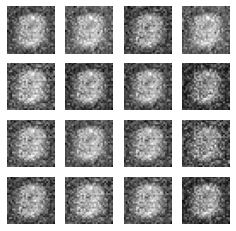

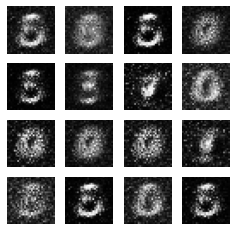

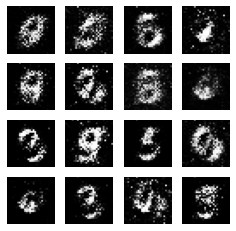

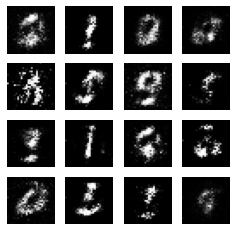

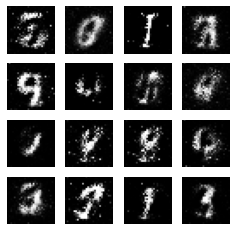

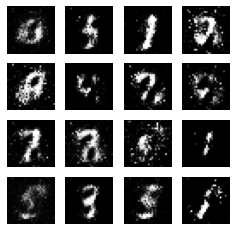

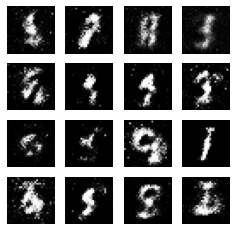

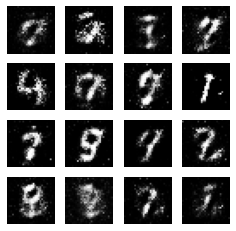

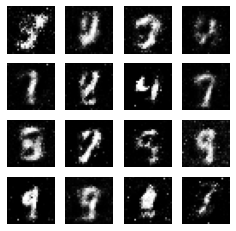

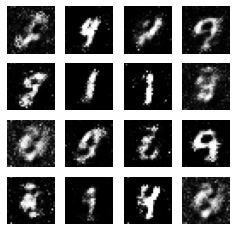

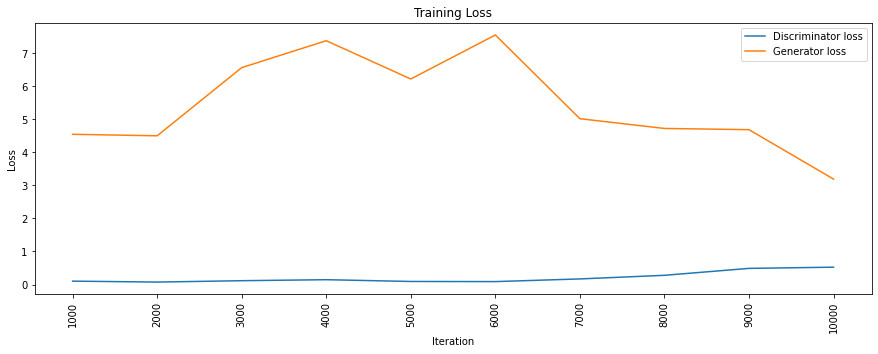

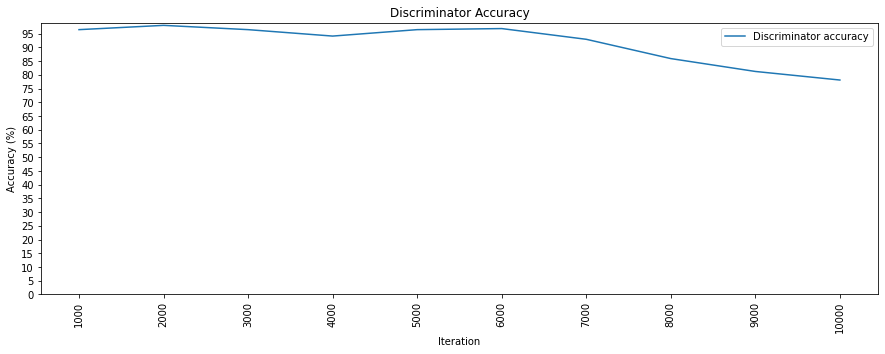

In [1]:

"""
Created on Thu Apr  9 15:26:55 2020

@author: preethasaha
"""

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1


def build_generator(img_shape, z_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28*28*1, activation='tanh'))
    
    model.add(Reshape(img_shape))
    
    return model
def build_discriminator(img_shape):
    model= Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

generator =  build_generator(img_shape, z_dim)

discriminator.trainable= False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train,_),(_,_)= mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx  = np.random.randint(0,X_train.shape[0],batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)
            
        
        
        
    
iterations = 10000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)


losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()  



accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
     